In [9]:
import os
import pandas as pd
import pandas_profiling as pf
import numpy as np
import matplotlib.pyplot as plt

In [10]:
#Initializing file paths
raw_dir = os.path.join(os.pardir,os.pardir,'data','raw')
processed_dir = os.path.join(os.pardir,os.pardir,'data','processed')

In [22]:
preds = os.path.join(raw_dir,'test_pred_.csv')
preds_proc = os.path.join(processed_dir,'test_pred_.csv')

In [34]:
preds_df = pd.read_csv(preds_proc,index_col='Unnamed: 0')

In [35]:
preds_df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,age_class
0,1,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0,middle-age
1,0,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0,middle-age
2,0,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0,middle-age
3,0,0.280308,38,1,0.925961,3200.0,7,0,2,0,0.0,middle-age
4,1,1.000000,27,0,0.019917,3865.0,4,0,0,0,1.0,youth


Before beginning analysis some key understanding to have:  
   
SeriousDlqin2yrs = 0 (positive outcome): means ADS is predicting the individual will not suffer a financial problem within the next two years and so the bank can consider this individual for a line of credit.

SeriousDlqin2yrs = 1 (negative outcome): means ADS is predicting the individual will suffer a financial problem within the next two years and for that reason the bank should not consider this individual for a line of credit.

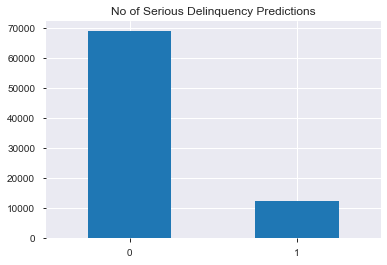

In [15]:
preds_df.SeriousDlqin2yrs.value_counts().plot(kind='bar',rot=0,title='No of Serious Delinquency Predictions')

Comparatively the ADS seems improved just slightly in termto follow similar distribution on the training data even after balancing the data. for obvious reason the

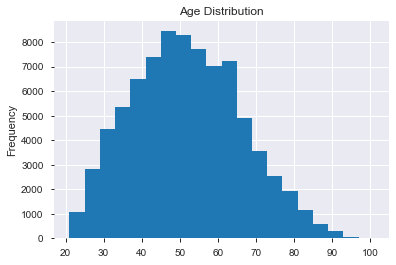

In [16]:
preds_df.age.plot(kind='hist',title='Age Distribution', bins=20)

To further understand what is happening in terms of protected feature we created an age class feature in the predicted dataset similar to what we did on the training set. The aim is to understand how the ADS made its decisions in relation to protected features (age and age_class).

In [17]:
def age_class(age):
    if age < 18 :
        return 'child'
    if age < 35:
        return 'youth'
    if age < 60:
        return 'middle-age'
    else:
        return 'senior'

In [18]:
preds_df['age_class'] = preds_df['age'].apply(lambda x: age_class(x))

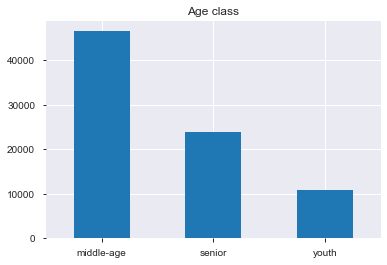

In [19]:
preds_df.age_class.value_counts().plot(kind='bar', rot=0, title='Age class')

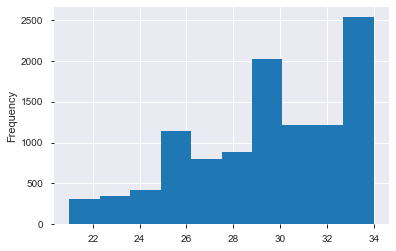

In [20]:
preds_df.age[preds_df.age_class=='youth'].plot(kind='hist')

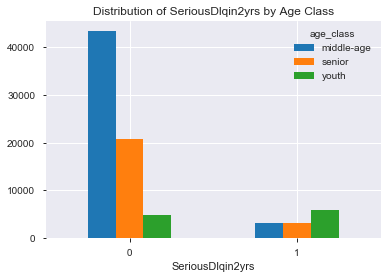

In [21]:
pd.crosstab(preds_df.SeriousDlqin2yrs, preds_df.age_class).plot(kind='bar',rot=1,title='Distribution of SeriousDlqin2yrs by Age Class')

From the above graph it is clear that our ADS predicted that more young people will have financial trouble in the next 2 years than other age brackets. To clearly understand this we will do a more in-depth analysis of the ADS to see how fair/unfair it is to young people and othe age categories.

#### Fairness Analysis:

When want to answer two key questions:
1. Is this ADS biased? or Not?
2. If it is then who does it favour and whom does it punish?

In [25]:
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from IPython.display import Markdown, display

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
preds_df.columns

Index(['index', 'SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines',
       'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio',
       'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans',
       'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines',
       'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents',
       'age_class'],
      dtype='object')

In [49]:
# mapping age_class to integers unprivileged: 0 and privileged:1
age_map = {'youth':0,'middle-age':1,'senior':2}

In [51]:
preds_df['age_class'] = preds_df['age_class'].apply(lambda x: age_map[x])

In [52]:
preds_df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,age_class
0,1,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0,1
1,0,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0,1
2,0,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0,1
3,0,0.280308,38,1,0.925961,3200.0,7,0,2,0,0.0,1
4,1,1.000000,27,0,0.019917,3865.0,4,0,0,0,1.0,0


In [63]:
unprivileged_groups = [{'age_class':0}]
privileged_groups = [{'age_class':1}]

In [60]:
kwargs = {'df':preds_df,
          'label_names':['SeriousDlqin2yrs'],
          'protected_attribute_names':['age_class'],
          'unprivileged_protected_attributes':0.0,
          'privileged_protected_attributes':1.0
         }

preds_aif360 = BinaryLabelDataset(favorable_label=0.0,
                                  unfavorable_label=1.0,
                                  **kwargs)

In [61]:
preds_aif360.features.shape

(81400, 11)

### Computing Fairness Metrics on Our ADS

#### Fairness Attribute 1: Disparate Impact:

In [65]:
ads_metrics = BinaryLabelDatasetMetric(preds_aif360,
                         unprivileged_groups=unprivileged_groups, 
                         privileged_groups=privileged_groups)

print("Disparate Impact = %f" % ads_metrics.disparate_impact())

Disparate Impact = 0.484234


A value less than 1 implies higher benefit for the priviledge group (middle-age) and a value greater than 1 implies a higher benefit for the unprivilege group ('youths'). 

With a value of 0.484234, our ADS is more likely to favour a 'middle-age' individual to qualify for a line of credit than a young person. 

#### Fairness Attribute 2: Base Rate (Probability of Positive Outcome Given You Belong to unprivilege group)


In [69]:
print("Base Rate (for unprivileged group) = %f" % ads_metrics.base_rate(privileged=False))

Base Rate (for unprivileged group) = 0.451184


What this base_rate tells us is that if you are a youth, our ADS is likely not to recommend you for a line of credit. What this mean is that for a youth to obtain a line of credit, a random coin flip (50:50) will provide you will be more fair in deciding your fate than our ADS.

#### Fairness Attribute 3: Base Rate (Probability of Positive Outcome Given You Belong to privilege group)


In [70]:
print("Base Rate (for privileged group) = %f" % ads_metrics.base_rate(privileged=True))

Base Rate (for privileged group) = 0.931747


What we see with these base rate is that 9 out of 10 middle-aged individuals will ALWAYS get a favourable decision from our ADS. While only 4 out of 10 youths will ever get a favourable decision if this is not unfair then I don't know what is.

**Conclusion:**  
The ADS we studied is biased and unfair to a very large extent as we have seen from the analysis even though it achieved a AUC of 86.95% in the Kaggle [Competition](https://www.kaggle.com/c/GiveMeSomeCredit/leaderboard "Give Me Some Credit | Kaggle"). This goes on to further prove that while we strive to build high performing and accurate models, we should also take care not to imbibe the continous injustice in our society within these systems.